## **Import Libraries and Install Packages**

In [ ]:
import re
import os
import time
from typing import TypedDict, Literal
from IPython.display import Image, display

!pip install langgraph
!pip install langchain-google-genai # Install the 'langchain-google-genai' package.

from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate
from google.colab import userdata
import google.generativeai as genai
from langchain_google_genai import GoogleGenerativeAI

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.0 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.4 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.16 which is incompatible.


## **Configure API and Initialize Models**

In [ ]:
# Retrieve and configure the API key
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")
genai.configure(api_key=GEMINI_API_KEY)
llm = GoogleGenerativeAI(google_api_key=GEMINI_API_KEY, model="gemini-1.5-flash")
print(llm)

GoogleGenerativeAI
Params: {'model': 'gemini-1.5-flash', 'temperature': 0.7, 'top_p': None, 'top_k': None, 'max_output_tokens': None, 'candidate_count': 1}


## **Define the STATE Data Structure**

In [ ]:
class STATE(TypedDict):
    """Represents the state of the essay grading process."""
    essay: str
    relevence_score: float
    grammar_score: float
    fluency_score: float
    vocabulary_score: float
    overall_score: float
    suggested_edits: str
    topic: str


## **Define Helper Functions**

In [ ]:
def get_score(content: str) -> float:
    """Extract the numeric score from the LLM's response."""
    match = re.search(r'Score:\s*(\d+(\.\d+)?)', content)
    if match:
        return float(match.group(1))
    else:
        print(f"Warning: Could not extract score from response: {content}")
        return 0


## **Define Scoring Functions**

In [ ]:
def check_relevance(state: STATE) -> STATE:
    """Check the relevance of the essay."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the relevance of the following essay to the given topic. "
        "Provide a relevance score between 0 and 1. If the essay is completely off topic, do not exceed the score by 1. "
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nTopic: {topic}\nEssay: {essay}"
    )
    prompt_string = prompt.format_prompt(essay=state["essay"], topic=state["topic"]).to_string()
    response = llm(prompt_string)
    state["relevence_score"] = get_score(response)
    return state

def check_grammar(state: STATE) -> STATE:
    """Check the grammar of the essay."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the grammar of the following essay. "
        "Provide a grammar score between 0 and 2. "
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nEssay: {essay}"
    )
    prompt_string = prompt.format_prompt(essay=state["essay"]).to_string()
    response = llm(prompt_string)
    state["grammar_score"] = get_score(response)
    return state

def check_fluency(state: STATE) -> STATE:
    """Check the fluency of the essay."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the fluency of the following essay. "
        "Provide a fluency score between 0 and 3. "
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nEssay: {essay}"
    )
    prompt_string = prompt.format_prompt(essay=state["essay"]).to_string()
    response = llm(prompt_string)
    state["fluency_score"] = get_score(response)
    return state

def check_vocabulary(state: STATE) -> STATE:
    """Check the vocabulary of the essay."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the vocabulary of the following essay. "
        "Provide a vocabulary score between 0 and 4. "
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nEssay: {essay}"
    )
    prompt_string = prompt.format_prompt(essay=state["essay"]).to_string()
    response = llm(prompt_string)
    state["vocabulary_score"] = get_score(response)
    return state

## **Define the Essay Grading and Suggestion Function**

In [ ]:
def suggest_edits(state: STATE) -> STATE:
    """Suggest edits to the essay."""
    prompt = ChatPromptTemplate.from_template(
        "You are an expert essay grader. Check the scores and suggest changes in the following essay to improve the score. "
        "Your response should start with reviewing the Score, provide your explanation why the essay was scored the way it is scored, "
        "and provide specific suggestions to improve the overall quality of the essay, focusing on clarity, relevance, grammar, and structure.\n\n"
        "Relevance Score: {relevence_score}\nGrammar Score: {grammar_score}\nFluency Score: {fluency_score}\nVocabulary Score: {vocabulary_score}\n\n"
        "Essay: {essay}\nTopic: {topic}"
    )
    prompt_string = prompt.format_prompt(
        relevence_score=state["relevence_score"], grammar_score=state["grammar_score"],
        fluency_score=state["fluency_score"], vocabulary_score=state["vocabulary_score"],
        essay=state["essay"], topic=state["topic"]
    ).to_string()
    response = llm(prompt_string)
    state["suggested_edits"] = response
    return state

def grade_essay(state: STATE) -> STATE:
    """Calculate the final grade of the essay based on all scores."""
    state = suggest_edits(state)
    state['overall_score'] = (state['relevence_score'] + state['grammar_score'] + state['fluency_score'] + state['vocabulary_score'])
    return state


## **Configure and Compile the StateGraph**

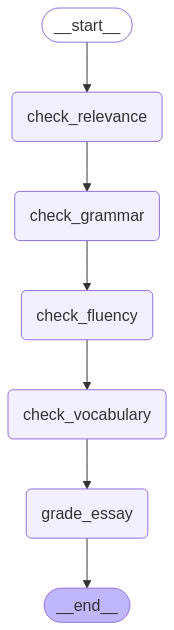

In [ ]:
# Initialize and configure the StateGraph
workflow = StateGraph(STATE)
workflow.set_entry_point("check_relevance")
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("check_grammar", check_grammar)
workflow.add_node("check_fluency", check_fluency)
workflow.add_node("check_vocabulary", check_vocabulary)
workflow.add_node("grade_essay", grade_essay)
workflow.add_edge("check_relevance", "check_grammar")
workflow.add_edge("check_grammar", "check_fluency")
workflow.add_edge("check_fluency", "check_vocabulary")
workflow.add_edge("check_vocabulary", "grade_essay")
workflow.add_edge("grade_essay", END)

# Compile the graph
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))  # Optionally display the workflow graph


## **Define the Function to Get Grades and Display Results**

In [ ]:
def grade_essay(state: STATE) -> STATE:
    """Calculate the final grade of the essay based on the sum of all scores."""
    # Sum the scores directly
    state['overall_score'] = (state['relevence_score'] + state['grammar_score'] +
                              state['fluency_score'] + state['vocabulary_score'])

    # Apply any suggested edits based on the scoring
    state = suggest_edits(state)
    return state


    time.sleep(1)  # Simulate processing delay
    initial_state = dict(
        essay=content,
        relevence_score=0.0,
        grammar_score=0.0,
        fluency_score=0.0,
        vocabulary_score=0.0,
        overall_score=0.0,
        suggested_edits="",
        topic=topic,
    )
    result = graph.invoke(initial_state)
    return result


## **IELTS essay sample from Chatgpt**

- Enter The Topic: Some people think that the best way to increase road safety is to increase the minimum legal age for driving cars or riding motorbikes. To what extent do you agree or disagree?
- Enter Your Essay: The proposition to enhance road safety by raising the minimum legal age for drivers and motorcyclists is a topic that garners substantial public and scholarly interest. While this approach may seem prudent at first glance, its effectiveness in reducing road accidents is debatable. I partially agree with this assertion, as I believe that while age can influence driving behavior, it is not the sole factor that affects road safety.  Proponents of increasing the minimum legal age argue that younger drivers typically lack the maturity required to navigate the complexities of driving. Statistics often support this view, suggesting that road accidents are disproportionately higher among younger drivers, primarily due to their propensity for risk-taking and less developed decision-making skills. By increasing the legal driving age, it is presumed that drivers would have more maturity and potentially better judgment, thus reducing the likelihood of accidents.  However, this perspective does not consider the comprehensive nature of driving skills, which are not solely matured with age but with experience and education. Raising the legal age does not guarantee that all new drivers are inherently safer. Young adults may still lack experience, which is crucial for safe driving. There is a strong case to be made for enhancing driver education programs instead of changing the legal age. By implementing more rigorous and comprehensive driving curricula that include simulated road experiences, hazard perception, and defensive driving tactics, new drivers can be better prepared for the challenges of the road, regardless of their age.  Furthermore, the effectiveness of such a policy can vary significantly between urban and rural areas. In rural regions where public transportation may be less accessible, driving is often not just a convenience but a necessity. Increasing the legal driving age could disproportionately affect these communities, limiting the mobility of young individuals who rely on driving to commute to educational institutions or workplaces.  Moreover, focusing on age overlooks other crucial aspects of road safety, such as the condition of vehicles and road infrastructure, enforcement of traffic laws, and the role of pedestrian behavior. A holistic approach to road safety would include strict enforcement of traffic regulations, regular maintenance of infrastructure, and public education campaigns that promote safe driving practices.  In conclusion, while increasing the minimum legal age for driving might contribute marginally to enhancing road safety, it is not a panacea. A multi-faceted approach that includes improved driver education, better law enforcement, and infrastructure development is likely to be more effective. Therefore, the focus should not be solely on who is allowed to drive but on how we can make all drivers safer on the roads.

**GPT4 SCore this essay as:**

- Relevance Score: 1/1
- Grammar Score: 2/2
- Fluency Score: 3/3
- Vocabulary Score: 3.5/4
- Final Essay Score: 9.5/10

**Llama score this essay as:**

- Relevance Score: 0.8/1
- Grammar Score: 1.8/2
- Fluency Score: 2.5/3
- Vocabulary Score: 3.2/4
- Final Essay Score: 8.3/10

In [ ]:
# Sample run
result = get_Grade(input("Enter The Topic: "), input("Enter Your Essay: "))
print(f"Relevance Score: {result['relevence_score']:.1f}/1")  # Assuming max is 1 for relevance
print(f"Grammar Score: {result['grammar_score']:.1f}/2")      # Assuming max is 2 for grammar
print(f"Fluency Score: {result['fluency_score']:.1f}/3")      # Assuming max is 3 for fluency
print(f"Vocabulary Score: {result['vocabulary_score']:.1f}/4")  # Assuming max is 4 for vocabulary
print(f"Final Essay Score: {result['overall_score']:.1f}/10\n\n")  # Display the final score by adding all scores
print(f"--Suggested Improvements:\n{result['suggested_edits']}")


Enter The Topic: Some people think that the best way to increase road safety is to increase the minimum legal age for driving cars or riding motorbikes. To what extent do you agree or disagree?
Enter Your Essay: The proposition to enhance road safety by raising the minimum legal age for drivers and motorcyclists is a topic that garners substantial public and scholarly interest. While this approach may seem prudent at first glance, its effectiveness in reducing road accidents is debatable. I partially agree with this assertion, as I believe that while age can influence driving behavior, it is not the sole factor that affects road safety.  Proponents of increasing the minimum legal age argue that younger drivers typically lack the maturity required to navigate the complexities of driving. Statistics often support this view, suggesting that road accidents are disproportionately higher among younger drivers, primarily due to their propensity for risk-taking and less developed decision-maki

**poor quality essay**

- Enter The Topic: The Influence of Social Media on Teenagers
- Enter Your Essay: Social media is bad for teenagers because it distracts them from their homework. Many teenagers spend a lot of time on Facebook and Instagram where they talk to friends and look at videos. This means they have less time for homework. Social media can also make teenagers feel bad because everyone is trying to show their best life, even if it's not real. Parents should make rules about how much time their kids can spend on social media.


- Relevance Score: 0.5/1
- Grammar Score: 1/2
- Fluency Score: 1/3
- Vocabulary Score: 1/4
- Final Essay Score: 3.5/10

In [ ]:
# Sample run
result = get_Grade(input("Enter The Topic: "), input("Enter Your Essay: "))
print(f"Relevance Score: {result['relevence_score']:.1f}/1")  # Assuming max is 1 for relevance
print(f"Grammar Score: {result['grammar_score']:.1f}/2")      # Assuming max is 2 for grammar
print(f"Fluency Score: {result['fluency_score']:.1f}/3")      # Assuming max is 3 for fluency
print(f"Vocabulary Score: {result['vocabulary_score']:.1f}/4")  # Assuming max is 4 for vocabulary
print(f"Final Essay Score: {result['overall_score']:.1f}/10\n\n")  # Display the final score by adding all scores
print(f"--Suggested Improvements:\n{result['suggested_edits']}")

Enter The Topic: The Influence of Social Media on Teenagers
Enter Your Essay: Social media is bad for teenagers because it distracts them from their homework. Many teenagers spend a lot of time on Facebook and Instagram where they talk to friends and look at videos. This means they have less time for homework. Social media can also make teenagers feel bad because everyone is trying to show their best life, even if it's not real. Parents should make rules about how much time their kids can spend on social media.
Relevance Score: 0.7/1
Grammar Score: 1.5/2
Fluency Score: 2.0/3
Vocabulary Score: 1.0/4
Final Essay Score: 5.2/10


--Suggested Improvements:
## Essay Review and Improvement Suggestions

The essay received a low overall score due to weaknesses across several key areas. Let's break down the scores and suggest improvements:

**Relevance Score: 0.7**  This low score indicates the essay only partially addresses the broad topic "The Influence of Social Media on Teenagers." While it 

**Essay from 6500 Ellipse corpus**

- Grammer score = 3.5
- vocabulary = 3.5

In [ ]:
# Sample run
result = get_Grade(input("Enter The Topic: "), input("Enter Your Essay: "))
print(f"Relevance Score: {result['relevence_score']:.1f}/1")  # Assuming max is 1 for relevance
print(f"Grammar Score: {result['grammar_score']:.1f}/2")      # Assuming max is 2 for grammar
print(f"Fluency Score: {result['fluency_score']:.1f}/3")      # Assuming max is 3 for fluency
print(f"Vocabulary Score: {result['vocabulary_score']:.1f}/4")  # Assuming max is 4 for vocabulary
print(f"Final Essay Score: {result['overall_score']:.1f}/10\n\n")  # Display the final score by adding all scores
print(f"--Suggested Improvements:\n{result['suggested_edits']}")

Enter The Topic: Cell phones at school
Enter Your Essay: Dear, TEACHER_NAME  I think phone policy at school should not let students use their phone during class or free time. For several reasons. First, school has to be an area of education and not of free time. Because in my point of view its a distraction to your self and the people around you. Second, phones could get stolen by the people you don't get along with. Also, another reason for school policy to know is that it can cause drama between friends and also people you don't know. Finally , phones can cause cheating, cheating is what school doesn't want so that's one of my main reasons why i don't want phones being used in school hours,
Relevance Score: 0.9/1
Grammar Score: 1.0/2
Fluency Score: 1.0/3
Vocabulary Score: 1.0/4
Final Essay Score: 3.9/10


--Suggested Improvements:
## Essay Review and Improvement Suggestions

**Score Review:**

The essay received a relatively high score for grammar, fluency, and vocabulary (all 1.0), 

## **GMAT sample essay**
 - Enter The Topic: The best way to understand the character of a society is by examining the character of the men and women that the society chooses as its heroes or its role models.
Enter Your Essay: Societal values and ideals are often reflected in the individuals who are revered and celebrated within that community. The assertion that understanding a society's character can be accomplished by analyzing its chosen heroes and role models is compelling and largely accurate. This essay will explore how societal heroes mirror the prevailing values and beliefs of their communities and how this insight provides a deep understanding of societal character.  Heroes are typically individuals who embody the qualities that are most valued by their society. For instance, a society that values innovation and entrepreneurship might revere business magnates and inventors as heroes. This can be seen in the United States, where figures like Steve Jobs and Elon Musk are celebrated for their groundbreaking contributions to technology and commerce. Their stories of perseverance, ingenuity, and success resonate deeply with American ideals of hard work and innovation leading to success.  Conversely, societies that place a high importance on civic duty and public service might hold politicians, activists, or humanitarian leaders in high regard. Such role models demonstrate commitment to community and service, qualities that are cherished within these societies. Nelson Mandela, for example, is a global symbol of resistance and leadership but particularly revered in South Africa for his role in dismantling apartheid, embodying the values of justice, resilience, and equality.  However, the proposition that heroes reflect societal values is not without its complications. Often, the heroes a society upholds are not a full representation of the society’s diversity or complexity. Sometimes, these figures might be idealized or their flaws overlooked due to the narrative that society wishes to promote. Additionally, in some cases, societal heroes are chosen by a select group of media or cultural gatekeepers, which might not accurately reflect the broader public's values.  Despite these nuances, the core idea remains robust. By examining those whom a society elevates to hero status, one can glean significant insights into what traits are most admired by that society. This analysis can reveal not only the aspirations and ideals of a community but also its biases and blind spots.  In conclusion, while it is critical to acknowledge that the choice of societal heroes can sometimes be narrow or biased, generally, these figures do provide valuable insights into the character and priorities of their societies. Understanding why certain individuals are celebrated helps to unravel the broader societal values and provides a clear reflection of what a society cherishes most.



**GPT4 score it as:**
 - Relevance Score: 1/1
 - Grammar Score: 2/2
 - Fluency Score: 3/3
 - Vocabulary Score: 4/4
- Final Essay Score: 10/10

**Llama\Meta AI score it as:**

- Relevance Score: 0.9/1
- Grammar Score: 1.9/2
- Fluency Score: 2.7/3
- Vocabulary Score: 3.5/4
- Final Essay Score: 8.9/10

In [ ]:
# Sample run
result = get_Grade(input("Enter The Topic: "), input("Enter Your Essay: "))
print(f"Relevance Score: {result['relevence_score']:.1f}/1")  # Assuming max is 1 for relevance
print(f"Grammar Score: {result['grammar_score']:.1f}/2")      # Assuming max is 2 for grammar
print(f"Fluency Score: {result['fluency_score']:.1f}/3")      # Assuming max is 3 for fluency
print(f"Vocabulary Score: {result['vocabulary_score']:.1f}/4")  # Assuming max is 4 for vocabulary
print(f"Final Essay Score: {result['overall_score']:.1f}/10\n\n")  # Display the final score by adding all scores
print(f"--Suggested Improvements:\n{result['suggested_edits']}")

Enter The Topic: The best way to understand the character of a society is by examining the character of the men and women that the society chooses as its heroes or its role models.
Enter Your Essay: Societal values and ideals are often reflected in the individuals who are revered and celebrated within that community. The assertion that understanding a society's character can be accomplished by analyzing its chosen heroes and role models is compelling and largely accurate. This essay will explore how societal heroes mirror the prevailing values and beliefs of their communities and how this insight provides a deep understanding of societal character.  Heroes are typically individuals who embody the qualities that are most valued by their society. For instance, a society that values innovation and entrepreneurship might revere business magnates and inventors as heroes. This can be seen in the United States, where figures like Steve Jobs and Elon Musk are celebrated for their groundbreakin

## **SAT essay:**
- Enter The Topic: Is compromise always the best way to resolve a conflict?
- Enter Your Essay: Compromise is often seen as a key method for resolving conflicts, as it allows both parties to reach a mutual agreement. Many believe that this is the best way to handle disagreements, whether in personal relationships, business, or international relations. This essay will explore whether compromise is indeed always the best method to resolve conflicts.  One major advantage of compromise is that it can preserve relationships. For example, in a workplace setting, when team members have differing opinions on a project, finding a middle ground can help avoid resentment and keep the team working together effectively. This can be crucial for the long-term success of business operations, where cooperation is often more beneficial than winning a particular argument.  However, compromise is not without its drawbacks. One issue is that it might not always lead to the best possible outcome. In some cases, compromising can result in a solution that is not optimal for either party. For instance, in political negotiations, compromising on important issues such as healthcare reform or environmental regulations can lead to watered-down policies that do not effectively address the problems they are meant to solve.  Additionally, compromise can be seen as a sign of weakness. In situations where one party is significantly more powerful than the other, the weaker party might feel forced into a compromise that is more beneficial to the stronger party. This can lead to further issues down the line, as the underlying conflict may not be truly resolved.  In conclusion, while compromise can be a useful tool for resolving disputes and preserving relationships, it is not always the best method. There are cases where aiming for a more decisive victory or holding firm on one's position can lead to better outcomes. Therefore, it is important to assess the situation carefully and decide whether compromise is indeed the most appropriate approach.


**GPT4 score as:**
- Relevance Score: 0.75/1
- Grammar Score: 1.5/2
- Fluency Score: 2/3
- Vocabulary Score: 2/4
- Final Essay Score: 6.25/10

**Llama\ Meta AI score as:**

- Relevance Score: 0.9/1
- Grammar Score: 1.9/2
- Fluency Score: 2.6/3
- Vocabulary Score: 3.3/4
- Final Essay Score: 8.7/10

In [ ]:
# Sample run
result = get_Grade(input("Enter The Topic: "), input("Enter Your Essay: "))
print(f"Relevance Score: {result['relevence_score']:.1f}/1")  # Assuming max is 1 for relevance
print(f"Grammar Score: {result['grammar_score']:.1f}/2")      # Assuming max is 2 for grammar
print(f"Fluency Score: {result['fluency_score']:.1f}/3")      # Assuming max is 3 for fluency
print(f"Vocabulary Score: {result['vocabulary_score']:.1f}/4")  # Assuming max is 4 for vocabulary
print(f"Final Essay Score: {result['overall_score']:.1f}/10\n\n")  # Display the final score by adding all scores
print(f"--Suggested Improvements:\n{result['suggested_edits']}")

Enter The Topic: Is compromise always the best way to resolve a conflict?
Enter Your Essay: Compromise is often seen as a key method for resolving conflicts, as it allows both parties to reach a mutual agreement. Many believe that this is the best way to handle disagreements, whether in personal relationships, business, or international relations. This essay will explore whether compromise is indeed always the best method to resolve conflicts.  One major advantage of compromise is that it can preserve relationships. For example, in a workplace setting, when team members have differing opinions on a project, finding a middle ground can help avoid resentment and keep the team working together effectively. This can be crucial for the long-term success of business operations, where cooperation is often more beneficial than winning a particular argument.  However, compromise is not without its drawbacks. One issue is that it might not always lead to the best possible outcome. In some cases,

## **GRE Analytical Writing Sample Essay Topic (Issue Task):**

- Enter The Topic: We learn our most valuable lessons from people who are similar to us, not from people who are different.
- Enter Your Essay: Learning is a dynamic process influenced by myriad factors, including the sources of our knowledge. While it is commonly believed that people similar to us are our best teachers because they share our experiences and perspectives, this view overlooks the profound lessons that can be learned from those who differ from us in culture, background, or ideology.  Proponents of learning from those similar to us argue that such individuals provide relatable examples and understandable lessons, which facilitate smoother learning experiences. For instance, a young athlete might find more practical value in the advice of a peer who has recently navigated the challenges of starting a professional sports career, as opposed to advice from someone outside the sports industry. This relevance is undoubtedly beneficial as it tailors the learning process to the learner’s immediate needs and context.  However, restricting our learning to only those who are similar limits our potential for growth. Interacting with people from diverse backgrounds can challenge our preconceived notions and push us to think critically about our beliefs and practices. For example, a business leader who only learns from peers within the same industry might never discover innovative practices adopted in other sectors, thus stunting potential innovative approaches to business challenges.  Moreover, diversity in learning exposes us to a broader range of problem-solving methods, enhancing our adaptability and creativity. It is often the novel perspective of an outsider that introduces a revolutionary solution that would not have been conceived within the echo chambers of similarity. History is replete with such examples, where cross-disciplinary approaches have led to breakthroughs that have reshaped industries.  In conclusion, while there is comfort and immediate relevance in learning from those who share our traits and experiences, the lessons we learn from people who are different are invaluable. They provide us with new perspectives, challenge our thinking, and equip us with a more comprehensive understanding of the world, which is essential in today’s globalized society.


**GPT4 scoring:**

- Relevance Score: 1/1
- Grammar Score: 1.5/2
- Fluency Score: 2.5/3
- Vocabulary Score: 3.5/4
- Final Essay Score: 8.5/10

**Llama\Meta AI score:**

- Relevance Score: 1/1
- Grammar Score: 2/2
- Fluency Score: 3/3
- Vocabulary Score: 4/4
- Final Essay Score: 10/10

In [ ]:
# Sample run
result = get_Grade(input("Enter The Topic: "), input("Enter Your Essay: "))
print(f"Relevance Score: {result['relevence_score']:.1f}/1")  # Assuming max is 1 for relevance
print(f"Grammar Score: {result['grammar_score']:.1f}/2")      # Assuming max is 2 for grammar
print(f"Fluency Score: {result['fluency_score']:.1f}/3")      # Assuming max is 3 for fluency
print(f"Vocabulary Score: {result['vocabulary_score']:.1f}/4")  # Assuming max is 4 for vocabulary
print(f"Final Essay Score: {result['overall_score']:.1f}/10\n\n")  # Display the final score by adding all scores
print(f"--Suggested Improvements:\n{result['suggested_edits']}")

Enter The Topic: We learn our most valuable lessons from people who are similar to us, not from people who are different.
Enter Your Essay: Learning is a dynamic process influenced by myriad factors, including the sources of our knowledge. While it is commonly believed that people similar to us are our best teachers because they share our experiences and perspectives, this view overlooks the profound lessons that can be learned from those who differ from us in culture, background, or ideology.  Proponents of learning from those similar to us argue that such individuals provide relatable examples and understandable lessons, which facilitate smoother learning experiences. For instance, a young athlete might find more practical value in the advice of a peer who has recently navigated the challenges of starting a professional sports career, as opposed to advice from someone outside the sports industry. This relevance is undoubtedly beneficial as it tailors the learning process to the learn

## **TOEFL Essay**

- Enter The Topic: Do you agree or disagree with the following statement? Technology has made children less creative than they were in the past. Use specific reasons and examples to support your answer.
- Enter Your Essay: In today’s digital era, technology permeates every aspect of our lives, including the way children play and learn. While some argue that technology has stifled children's creativity, I disagree with this statement. In fact, I believe that technology has not only preserved but enhanced children's creativity by providing them with more tools and platforms to express themselves and innovate.  Firstly, technology offers a myriad of applications and software that encourage creative expression. For example, apps like Toca Boca and digital platforms like Scratch allow children to design their own games and stories, fostering not just interaction but creation. Children can animate characters, build virtual worlds, and solve problems in ways that were unimaginable just a few decades ago. This kind of interactive and digital creation is a direct extension of children’s creative faculties.  Moreover, the internet provides children with access to a global library of information and ideas, broadening their horizons more than ever before. With resources such as online tutorials, children can learn anything from painting and drawing to coding and music production at an early age. This access not only inspires them with ideas from different cultures but also equips them with the skills to turn their imaginative concepts into reality.  However, it is crucial to acknowledge that technology can become a distraction if not used wisely. Excessive consumption of passive content, like watching videos or playing pre-designed video games, might indeed limit creative thinking. Therefore, the key lies in how technology is used. Active engagement, rather than passive consumption, is what truly nurtures creativity. Parents and educators play a significant role in guiding children towards constructive use of technology.  In conclusion, technology by itself does not make children less creative. Rather, it provides a new canvas and a broader set of tools for creative expression. As with all tools, its impact depends on how it is used. Guided and purposeful use of technology can significantly enhance children’s creativity, making them not less, but perhaps more creative than past generations.

**GPT4 Scores:**

- Relevance Score: 1/1
- Grammar Score: 1.5/2
- Fluency Score: 2.5/3
- Vocabulary Score: 3.5/4
- Final Essay Score: 8.5/10




**Llama\Meta AI score:**
- Relevance Score: 0.9/1
- Grammar Score: 1.9/2
- Fluency Score: 2.8/3
- Vocabulary Score: 3.8/4
- Final Essay Score: 9.4/10


In [ ]:
# Sample run
result = get_Grade(input("Enter The Topic: "), input("Enter Your Essay: "))
print(f"Relevance Score: {result['relevence_score']:.1f}/1")  # Assuming max is 1 for relevance
print(f"Grammar Score: {result['grammar_score']:.1f}/2")      # Assuming max is 2 for grammar
print(f"Fluency Score: {result['fluency_score']:.1f}/3")      # Assuming max is 3 for fluency or structure score
print(f"Vocabulary Score: {result['vocabulary_score']:.1f}/4")  # Assuming max is 4 for vocabulary
print(f"Final Essay Score: {result['overall_score']:.1f}/10\n\n")  # Display the final score by adding all scores
print(f"--Suggested Improvements:\n{result['suggested_edits']}")

Enter The Topic: Do you agree or disagree with the following statement? Technology has made children less creative than they were in the past. Use specific reasons and examples to support your answer.
Enter Your Essay: In today’s digital era, technology permeates every aspect of our lives, including the way children play and learn. While some argue that technology has stifled children's creativity, I disagree with this statement. In fact, I believe that technology has not only preserved but enhanced children's creativity by providing them with more tools and platforms to express themselves and innovate.  Firstly, technology offers a myriad of applications and software that encourage creative expression. For example, apps like Toca Boca and digital platforms like Scratch allow children to design their own games and stories, fostering not just interaction but creation. Children can animate characters, build virtual worlds, and solve problems in ways that were unimaginable just a few deca